#### GIT Link: https://github.com/RajeshBisht28/TableRowColumnPretrained
### **<span style="color:#00b4c7; align:center"> Objective: Prediction of Table Row/Column values.</span>**


#### Using Model loaders from the Hugging Face Transformers library.
<div>
<span style="color:#00b4c7; font-size:14px">1: AutoModelForObjectDetection : Model Loader for "microsoft/table-transformer-detection"
</span>
    </div>
<div>
    <span style="color:#00b4c7; font-size:14px">2: TableTransformerForObjectDetection : Model Loader for "microsoft/table-structure-recognition-v1.1-all"
</span>
</div>
<span style="color:#00b4c7; font-size:14px">3: TrOCRProcessor : Model Loader for "microsoft/trocr-base-printed"
</span>

 
### **<span style="color:#00b4c7;">CNN-Deep Learning: Image Processing Pipeline: Using Pretrained Models through Hugging Face </span>**

**Workflow**:  
<span style="color:#00b4c7; font-weight:bold;">Image Acquisition → Preprocessing → Filtering → Normalization → Transformation → Segmentation → Feature Extraction → Classification/Recognition → Postprocessing → Visualization/Output</span>

---

### **<span style="color:#00b4c7;">Overview of an Image Transformation Pipeline</span>**  
An image transformation pipeline is a sequence of steps or operations applied to images to convert them from one form to another or to extract useful information. It is commonly used in **image processing**, **computer vision**, and **machine learning** tasks.

---

### **<span style="color:#00b4c7;">Pipeline Steps</span>**

1. **🖼️ <span style="color:#00b4c7;">Image Acquisition</span>**  
   Capturing or obtaining the image from a source such as a camera, scanner, or an image file.

2. **🛠️ <span style="color:#00b4c7;">Preprocessing</span>**  
   Performing initial adjustments to the image, such as resizing, cropping, denoising, and correcting for brightness and contrast.

3. **🔍 <span style="color:#00b4c7;">Filtering</span>**  
   Applying filters to enhance or detect specific features like edge detection, blurring, or sharpening.

4. **📊 <span style="color:#00b4c7;">Normalization</span>**  
   Scaling image pixel values to a specific range (e.g., 0 to 1) to standardize inputs.

5. **⚙️ <span style="color:#00b4c7;">Transformation</span>**  
   Applying geometric changes such as rotation, scaling, and perspective adjustments.

6. **🧩 <span style="color:#00b4c7;">Segmentation</span>**  
   Dividing the image into meaningful regions or objects, crucial for object detection tasks.

7. **🌟 <span style="color:#00b4c7;">Feature Extraction</span>**  
   Identifying key features like edges, corners, or textures for model inputs.

8. **📚 <span style="color:#00b4c7;">Classification/Recognition</span>**  
   Using machine learning or deep learning models to classify images or detect objects.

9. **✨ <span style="color:#00b4c7;">Postprocessing</span>**  
   Refining outputs, such as smoothing or merging results.

10. **📈 <span style="color:#00b4c7;">Visualization/Output</span>**  
    Displaying or saving the processed image with annotations or extracted data.

---


In [580]:
####  load a version of the model revision="no_timm"

In [1]:
import warnings
warnings.filterwarnings("ignore")

from transformers import AutoModelForObjectDetection
table_detection_model = AutoModelForObjectDetection.from_pretrained("microsoft/table-transformer-detection", revision="no_timm")

config.json:   0%|          | 0.00/76.5k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

In [582]:
#### Image path which contain Table...
table_image_path = r"E:\TEST_FILES\image_tables\page2.png"
table_image_path = r"E:\TEST_FILES\image_data\Table.png"

##### Check Compute Unified Device Architecture (CUDA) from NVIDIA that accelerates machine learning and data science on GPUs.
Check if CUDA is available and set the device otherwise CPU.

In [583]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
table_detection_model.to(device)
print("")

##### Load image from local path, For Display do some scaling.

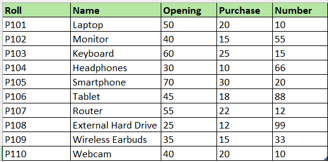

In [584]:
from PIL import Image
from huggingface_hub import hf_hub_download

image = Image.open(table_image_path).convert("RGB")
# let's display it a bit smaller
width, height = image.size
display(image.resize((int(0.6*width), (int(0.6*height)))))

In [585]:
from torchvision import transforms
class ImageScalerResizer(object):
    def __init__(self, max_size=800):
        self.max_size = max_size

    def __call__(self, image):
        w, h = image.size        
        scale = self.max_size / max(width, height)
        resized_image = image.resize((int(round(scale*w)), int(round(scale*h))))
        return resized_image

detection_transform = transforms.Compose([
    ImageScalerResizer(800),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
transformed_pixels = detection_transform(image).unsqueeze(0)
transformed_pixels = transformed_pixels.to(device)
print("========== Information of model transform =============")

# Get the dimensions
batch_size, channels, height, width = transformed_pixels.shape

# Display the dimensions values...
print(f"Batch size: {batch_size}")
print(f"Number of channels: {channels}")
print(f"Height: {height}")
print(f"Width: {width}")


========== Information of model transform =============
Batch size: 1
Number of channels: 3
Height: 396
Width: 800


#### using  CNN: convolutional layers : predict outcomes => using Pytorch library and table detection model 
- **There is ignore: Gradient calculation during prediction outcomes.**
- **outcomes: Context of neural networks, to refer to the raw, unnormalized output of a model.**

In [586]:
import torch
with torch.no_grad():
  outputs = table_detection_model(transformed_pixels)
outputs.logits.shape

torch.Size([1, 15, 3])

##### outputs.logits.shape : Refers :  torch.Size([1, 15, 3]) ==> 1=batch size, 15=number of objects or detections by model and 3=number of classes or categories

#### Extracts the predicted labels, scores, and bounding boxes from the model's output.

-**Applies softmax to the logits to get the probabilities for each class, and then takes the class with the highest probability.**

-**Rescales the bounding boxes to match the image size.**

-**Filters out predictions labeled as "no object".**

-**Returns a list of detected objects, each with its label, score, and bounding box coordinates.**

In [587]:
# update id2label to include "no object"
id2label = table_detection_model.config.id2label
id2label[len(table_detection_model.config.id2label)] = "no object"

#  post-processing for bounding boxes values
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(-1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h), (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)


def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def fetch_label_bbx_score(outputs, img_size, id2label):
    m = outputs.logits.softmax(-1).max(-1)
    pred_labels = list(m.indices.detach().cpu().numpy())[0]
    pred_scores = list(m.values.detach().cpu().numpy())[0]
    pred_bboxes = outputs['pred_boxes'].detach().cpu()[0]
    pred_bboxes = [elem.tolist() for elem in rescale_bboxes(pred_bboxes, img_size)]

    tableinfo = []
    for label, score, bbox in zip(pred_labels, pred_scores, pred_bboxes):
        class_label = id2label[int(label)]
        if not class_label == 'no object':
            tableinfo.append({'label': class_label, 'score': float(score),
                            'bbox': [float(elem) for elem in bbox]})

    return tableinfo

In [588]:
detected_table_boundry = fetch_label_bbx_score(outputs, image.size, id2label)

In [589]:
print(detected_table_boundry)

[{'label': 'table', 'score': 0.9997441172599792, 'bbox': [9.19443416595459, 6.62215518951416, 524.3612670898438, 263.3559875488281]}]


#### Visualize: Detected image. (Detected by table transform model)

In [590]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Patch

def fig2img(fig):
    """Convert a Matplotlib figure to a PIL Image and return it"""
    import io
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    img = Image.open(buf)
    return img


def visualize_detected_tables(img, det_tables, out_path=None):
    plt.imshow(img, interpolation="lanczos")
    fig = plt.gcf()
    fig.set_size_inches(20, 20)
    ax = plt.gca()

    for det_table in det_tables:
        bbox = det_table['bbox']
        ### increases the x-coordinate of the bottom-right corner by 15, effectively expanding the bounding box horizontally to the right.
        bbox[2] = bbox[2] ##+15
        if det_table['label'] == 'table':
            facecolor = (1, 0, 0.45)
            edgecolor = (1, 0, 0.45)
            alpha = 0.3
            linewidth = 2
            hatch= '~~~~~~'
        elif det_table['label'] == 'table rotated':
            facecolor = (0.95, 0.6, 0.1)
            edgecolor = (0.95, 0.6, 0.1)
            alpha = 0.3
            linewidth = 2
            hatch= '******'
        else:
            continue

        rect = patches.Rectangle(bbox[:2], bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=linewidth,
                                    edgecolor='none',facecolor=facecolor, alpha=0.1)
        ax.add_patch(rect)
        rect = patches.Rectangle(bbox[:2], bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=linewidth,
                                    edgecolor=edgecolor,facecolor='none',linestyle='-', alpha=alpha)
        ax.add_patch(rect)
        rect = patches.Rectangle(bbox[:2], bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=0,
                                    edgecolor=edgecolor,facecolor='none',linestyle='-', hatch=hatch, alpha=0.2)
        ax.add_patch(rect)

    plt.xticks([], [])
    plt.yticks([], [])

    legend_elements = [Patch(facecolor=(1, 0, 0.45), edgecolor=(1, 0, 0.45),
                                label='Table', hatch='~~~~~~', alpha=0.3),
                        Patch(facecolor=(0.95, 0.6, 0.1), edgecolor=(0.95, 0.6, 0.1),
                                label='Table (rotated)', hatch='******', alpha=0.3)]
    plt.legend(handles=legend_elements, bbox_to_anchor=(0.5, -0.02), loc='upper center', borderaxespad=0,
                    fontsize=10, ncol=2)
    plt.gcf().set_size_inches(10, 10)
    plt.axis('off')

    if out_path is not None:
      plt.savefig(out_path, bbox_inches='tight', dpi=150)

    return fig

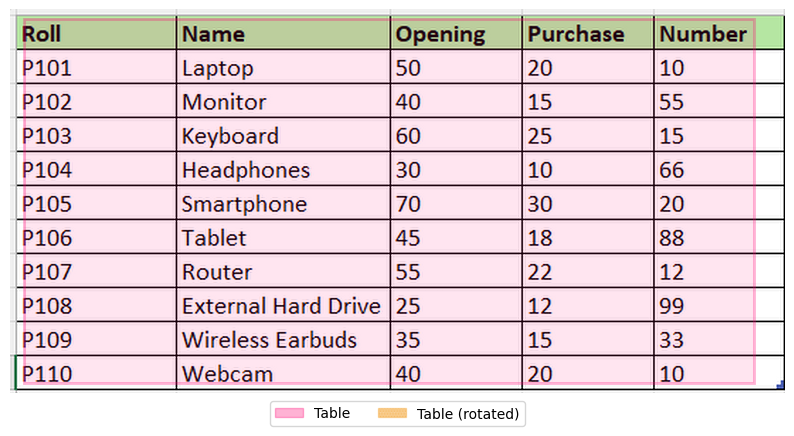

In [591]:
fig = visualize_detected_tables(image, detected_table_boundry)

In [592]:
visualized_image = fig2img(fig)

##### Crop table with some padding: using boundig boxes, label =>> For furthur processing
-**Table Transformer (TATR) model, padding suggest to adding extra space around the detected table region in an image.**

-**padding helps the model better recognize and process the table structure.**

In [3]:
def crops_table_object(img, tokens, objects, class_thresholds, padding=10):
    table_object = []
    for obj in objects:
        if obj['score'] < class_thresholds[obj['label']]:
            continue

        cropped_table = {}

        bbox = obj['bbox']
        bbox = [bbox[0]-padding, bbox[1]-padding, bbox[2]+padding, bbox[3]+padding]

        cropped_img = img.crop(bbox)

        table_tokens = [token for token in tokens if iob(token['bbox'], bbox) >= 0.5]
        for token in table_tokens:
            token['bbox'] = [token['bbox'][0]-bbox[0],
                             token['bbox'][1]-bbox[1],
                             token['bbox'][2]-bbox[0],
                             token['bbox'][3]-bbox[1]]

        # If table is predicted to be rotated, rotate cropped image and tokens/words:
        if obj['label'] == 'table rotated':
            cropped_img = cropped_img.rotate(270, expand=True)
            for token in table_tokens:
                bbox = token['bbox']
                bbox = [cropped_img.size[0]-bbox[3]-1,
                        bbox[0],
                        cropped_img.size[0]-bbox[1]-1,
                        bbox[2]]
                token['bbox'] = bbox

        cropped_table['image'] = cropped_img
        cropped_table['tokens'] = table_tokens

        table_object.append(cropped_table)

    return table_object

In [594]:
detected_table_boundry

[{'label': 'table',
  'score': 0.9997441172599792,
  'bbox': [9.19443416595459,
   6.62215518951416,
   524.3612670898438,
   263.3559875488281]}]

In [4]:
tokens = []
detection_class_thresholds = {
    "table": 0.5,
    "table rotated": 0.5,
    "no object": 10
}
crop_padding = 10

tables_crops = crops_table_object(image, tokens, detected_table_boundry, detection_class_thresholds, padding=0)
cropped_table = tables_crops[0]['image'].convert("RGB")
cropped_table

NameError: name 'image' is not defined

In [596]:
cropped_table.save("table2.jpg")

## Load structure recognition model

Next, we load a Table Transformer pre-trained for table structure recognition.

In [597]:
from transformers import TableTransformerForObjectDetection

# new v1.1 checkpoints require no timm anymore
structure_model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-structure-recognition-v1.1-all")
structure_model.to(device)
print("")

### Perform: Data preprocessing pipeline,

In [598]:
structure_transform = transforms.Compose([
    ImageScalerResizer(1000),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]) 
transformed_pixels = structure_transform(cropped_table).unsqueeze(0)
transformed_pixels = transformed_pixels.to(device)
print(transformed_pixels.shape)

torch.Size([1, 3, 320, 644])


### Prepare the cropped table image for the model, and perform a forward pass.

In [600]:
# forward pass
with torch.no_grad():
  outputs = structure_model(transformed_pixels)

Next, we get the predicted detections.

In [601]:
# update id2label to include "no object"
structure_id2label = structure_model.config.id2label
structure_id2label[len(structure_id2label)] = "no object"

cells = fetch_label_bbx_score(outputs, cropped_table.size, structure_id2label)
###>>>print(cells)

## Visualize cells

We can visualize all recognized cells using PIL's ImageDraw module.

cell counts: 18


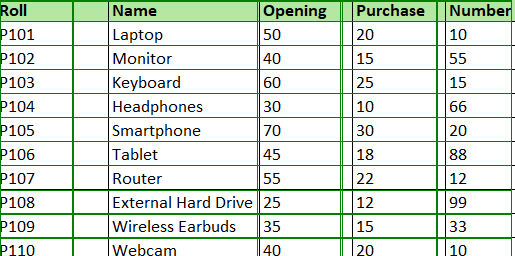

In [602]:
from PIL import ImageDraw

cropped_table_visualized = cropped_table.copy()
draw = ImageDraw.Draw(cropped_table_visualized)
print(f"cell counts: {len(cells)}")

for cell in cells:           
       draw.rectangle(cell["bbox"], outline="green")
    
cropped_table_visualized

An alternative way of plotting is to select one class to visualize, like "table row":

In [603]:
def plot_results(cells, class_to_visualize):
    if class_to_visualize not in structure_model.config.id2label.values():
      raise ValueError("Class should be one of the available classes")

    plt.figure(figsize=(16,10))
    plt.imshow(cropped_table)
    ax = plt.gca()

    for cell in cells:
        score = cell["score"]
        bbox = cell["bbox"]
        label = cell["label"]
        ## >>> print(f"label: {label}")
        if label == class_to_visualize:
          xmin, ymin, xmax, ymax = tuple(bbox)

          ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color="red", linewidth=3))
          text = f'{cell["label"]}: {score:0.2f}'
          ax.text(xmin, ymin, text, fontsize=15,
                  bbox=dict(facecolor='white', alpha=0.5))
          plt.axis('off')

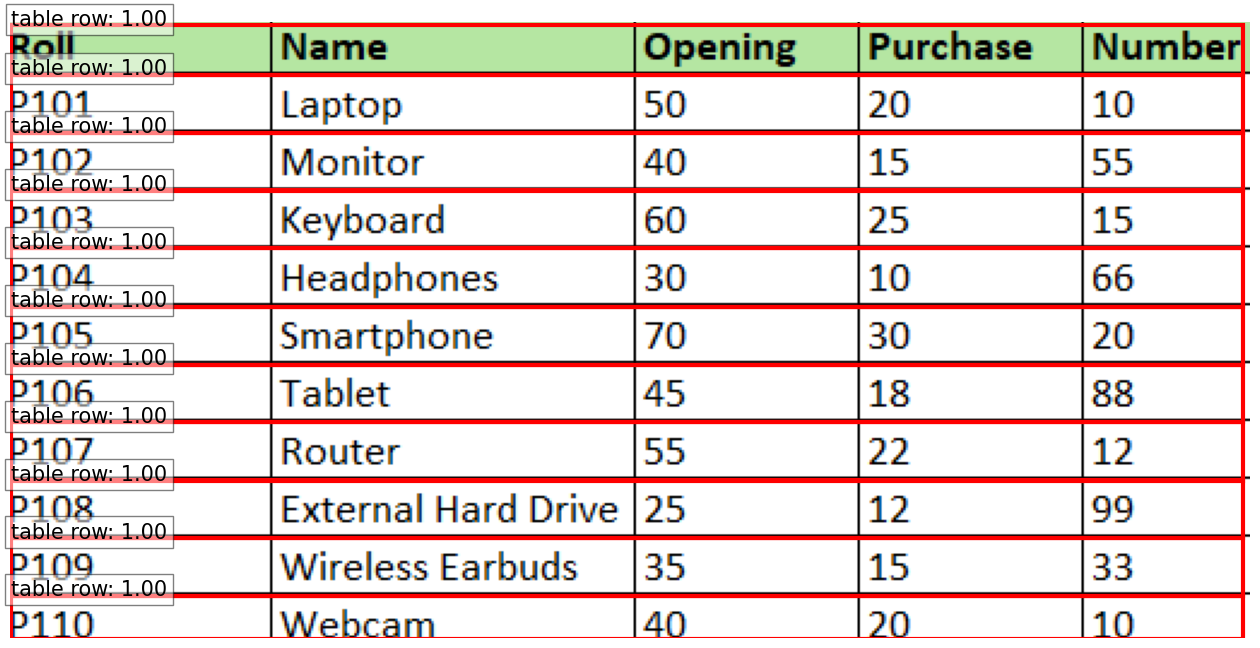

In [604]:
plot_results(cells, class_to_visualize="table row")

#### Courtesy: Copilot / GeminiAi / ChatGPT : Apply OCR row by row : ROI (Region of Interaction).
***Identify Intersections And Calculate Intersection Area:***

In [605]:
def get_cell_coordinates_by_row(table_data):
    # Extract rows and columns
    rows = [entry for entry in table_data if entry['label'] == 'table row']
    columns = [entry for entry in table_data if entry['label'] == 'table column']

    # Sort rows and columns by their Y and X coordinates, respectively
    rows.sort(key=lambda x: x['bbox'][1])
    columns.sort(key=lambda x: x['bbox'][0])

    # Function to find cell coordinates
    def find_cell_coordinates(row, column):
        cell_bbox = [column['bbox'][0], row['bbox'][1], column['bbox'][2], row['bbox'][3]]
        return cell_bbox

    # Generate cell coordinates and count cells in each row
    cell_coordinates = []

    for row in rows:
        row_cells = []
        for column in columns:
            cell_bbox = find_cell_coordinates(row, column)
            row_cells.append({'column': column['bbox'], 'cell': cell_bbox})

        # Sort cells in the row by X coordinate
        row_cells.sort(key=lambda x: x['column'][0])

        # Append row information to cell_coordinates
        cell_coordinates.append({'row': row['bbox'], 'cells': row_cells, 'cell_count': len(row_cells)})

    # Sort rows from top to bottom
    cell_coordinates.sort(key=lambda x: x['row'][1])

    return cell_coordinates

cell_coordinates = get_cell_coordinates_by_row(cells)

In [606]:
len(cell_coordinates)

11

In [607]:
len(cell_coordinates[0]["cells"])

5

### **<span style="color:#00b4c7;">Alternate for OCR : model : microsoft/trocr-base-printed</span>** 
**EasyOCr is primary: if EasyOCr unable to read then use Trocr Model.**

In [614]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
import torch

ocr_processor = TrOCRProcessor.from_pretrained('microsoft/trocr-base-printed')
ocr_model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-base-printed')

def apply_trocr(cell_image, ocr_processor=ocr_processor, ocr_model=ocr_model ):
    pix_vals = ocr_processor(images=cell_image, return_tensors="pt").pixel_values
    gen_ids = ocr_model.generate(pix_vals)
    gen_text = ocr_processor.batch_decode(gen_ids, skip_special_tokens=True)[0]
    return gen_text
    

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": false,
  "transformers_version": "4.48.0.dev0"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 768,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "de

#### Using EasyOcr : Read and Collect Text. (Alternate TrOCr pretrained model also using.)

In [609]:
import numpy as np
import csv
import easyocr
from tqdm.auto import tqdm

reader = easyocr.Reader(['en'])

def apply_ocr(cell_coordinates):
    # let's OCR row by row
    data = dict()
    max_num_columns = 0
    indx = 0
    for idx, row in enumerate(tqdm(cell_coordinates)):
      row_text = []
      for cell in row["cells"]:
        indx = indx + 1
        # crop cell out of image
        cell_image = np.array(cropped_table.crop(cell["cell"]))
        # apply OCR
        result = reader.readtext(np.array(cell_image))
        if len(result) > 0:
          # print([x[1] for x in list(result)])
          text = " ".join([x[1] for x in result])
          row_text.append(text)
        else:  ## >> testing-comment          
          image_to_ocr = Image.fromarray(cell_image)
          text = apply_trocr(image_to_ocr)
          row_text.append(text)

      if len(row_text) > max_num_columns:
          max_num_columns = len(row_text)

      data[idx] = row_text

    print("Max number of columns:", max_num_columns)

    # pad rows which don't have max_num_columns elements
    # to make sure all rows have the same number of columns
    for row, row_data in data.copy().items():
        if len(row_data) != max_num_columns:
          row_data = row_data + ["" for _ in range(max_num_columns - len(row_data))]
        data[row] = row_data

    return data

data = apply_ocr(cell_coordinates)

for row, row_data in data.items():
    print(row_data)

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


  0%|          | 0/11 [00:00<?, ?it/s]

Max number of columns: 5
['Roll', 'Name', 'Opening', 'Purchase', 'Number']
['P101', 'Laptop', '50', '20', '10']
['P102', 'Monitor', '40', '15', '55']
['P103', 'Kevboard', '60', '25', '15']
['P104', 'Headphones', '30', '10', '66']
['P105', 'Smartphone', '70', '30', '20']
['P106', 'Tablet', '45', '18', '88']
['P107', 'Router', '55', '22', '12']
['P108', 'External Hard Drive', '25', '12', '99']
['P10g', 'Wireless Earbuds', '35', '15', '33']
['P11O', 'Webcam', '40', '20', '10']


## Save as CSV

We end up with a CSV file containing the data.

In [610]:
import csv
try:
    if os.path.exists("output.csv"):
     os.remove("output.csv")
except:
    pass
        
with open('output.csv','w') as result_file:
    wr = csv.writer(result_file, dialect='excel')

    for row, row_text in data.items():
      wr.writerow(row_text)

In [611]:
import pandas as pd

df = pd.read_csv("output.csv")
df.head()

,Roll,Name,Opening,Purchase,Number
0,P101,Laptop,50,20,10
1,P102,Monitor,40,15,55
2,P103,Kevboard,60,25,15
3,P104,Headphones,30,10,66
4,P105,Smartphone,70,30,20


In [1]:
pip install --upgrade jupyter nbconvert

  Attempting uninstall: nbconvert
    Found existing installation: nbconvert 7.16.4
    Uninstalling nbconvert-7.16.4:
      Successfully uninstalled nbconvert-7.16.4
  Attempting uninstall: jupyter
    Found existing installation: jupyter 1.0.0
    Uninstalling jupyter-1.0.0:
      Successfully uninstalled jupyter-1.0.0
Note: you may need to restart the kernel to use updated packages.


In [1]:
pip install -U jupyter

Note: you may need to restart the kernel to use updated packages.
